In [1]:
#all_slow

# Tutorial: Fine-Tuning Sequence Classification on CSV Files with IMDB
> Tuning a Sequence Classification model on the IMDB Dataset

## Introduction

In this tutorial we will be showing an end-to-end example of fine-tuning a Transformer for sequence classification on a custom dataset in CSV file format.

By the end of this you should be able to:

1. Build a dataset with the `SequenceClassificationDatasets` class, and their DataLoaders
2. Build a `SequenceClassificationTuner` quickly, find a good learning rate, and train with the One-Cycle Policy
3. Save that model away, to be used with deployment or other HuggingFace libraries
4. Apply inference using both the `Tuner` available function as well as with the `EasySequenceClassifier` class within AdaptNLP

## Installing the Library

This tutorial utilizies the latest AdaptNLP version, as well as parts of the `fastai` library. Please run the below code to install them:

In [1]:
# !pip install git+https://github.com/novetta/adaptnlp@dev -U

In [1]:
#hide
from nbverbose.showdoc import *

## Getting the Dataset

First we need a dataset. We will use the `fastai` library to download the `IMDB_SAMPLE` dataset, a subset of IMDB Movie Reviews.

In [3]:
from fastai.data.external import URLs, untar_data

`URLs` holds a namespace of many data endpoints, and `untar_data` is a function that can download and extract any data from a given URL.

Combining both, we can download the data:

In [4]:
data_path = untar_data(URLs.IMDB_SAMPLE)

If we look at what was downloaded, we will find a `texts.csv` file:

In [5]:
data_path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

This is our data we want to use. This CSV is formatted with a table of columns with `label`, `text`, and `is_valid` dictating whether it is part of the validation set or not. 

Now that we have the dataset, and we know the format it is in, let's pick a viable model to train with

## Picking a Model with the Hub

AdaptNLP has a `HFModelHub` class that allows you to communicate with the HuggingFace Hub and pick a model from it, as well as a namespace `HF_TASKS` class with a list of valid tasks we can search by.

Let's try and find one suitable for sequence classification.

First we need to import the class and generate an instance of it:

In [6]:
from adaptnlp import HFModelHub, HF_TASKS

In [7]:
hub = HFModelHub()

Next we can search for a model:

In [8]:
models = hub.search_model_by_task(
    task=HF_TASKS.TEXT_CLASSIFICATION
)

Let's look at a few:

In [9]:
models[:10]

[Model Name: distilbert-base-uncased-finetuned-sst-2-english, Tasks: [text-classification],
 Model Name: roberta-base-openai-detector, Tasks: [text-classification],
 Model Name: roberta-large-mnli, Tasks: [text-classification],
 Model Name: roberta-large-openai-detector, Tasks: [text-classification]]

These are models specifically tagged with the `text-classification` tag, so you may not see a few models you would expect such as `bert_base_cased`.

We'll use that first model, `distilbert-base-uncased`:

In [10]:
model = models[0]

In [11]:
model

Model Name: distilbert-base-uncased-finetuned-sst-2-english, Tasks: [text-classification]

Now that we have picked a model, let's use the data API to prepare our data

> Note: It should be mentioned that this is optional, you can always just pass in the string name of a model such as "bert-base-cased"

## Building `TaskDatasets` with `SequenceClassificationDatasets`

Each task has a high-level data wrapper around the `TaskDatasets` class. In our case this is the `SequenceClassificationDatasets` class:

In [12]:
from adaptnlp import SequenceClassificationDatasets

There are multiple different constructors for the `SequenceClassificationDatasets` class, and you should never call the main constructor directly.

We will be using `from_csvs`, which wraps around the `from_dfs` constructor:

In [13]:
show_doc(SequenceClassificationDatasets.from_csvs)

<h4 id="SequenceClassificationDatasets.from_csvs" class="doc_header"><code>SequenceClassificationDatasets.from_csvs</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L114" class="source_link" style="float:right">[source]</a></h4>

> <code>SequenceClassificationDatasets.from_csvs</code>(**`train_csv`**:`Path`, **`text_col`**:`str`, **`label_col`**:`str`, **`tokenizer_name`**:`str`, **`tokenize`**:`bool`=*`True`*, **`is_multicategory`**:`bool`=*`False`*, **`label_delim`**=*`' '`*, **`valid_csv`**:`Path`=*`None`*, **`split_func`**=*`None`*, **`split_pct`**=*`0.2`*, **`tokenize_kwargs`**:`dict`=*`{}`*, **`auto_kwargs`**:`dict`=*`{}`*, **\*\*`kwargs`**)

Builds `SequenceClassificationDatasets` from a single csv or set of csvs. A convience constructor for `from_dfs`

**Function Arguments**:
* `train_csv` (`Path`): A training csv file
* `text_col` (`str`): The name of the text column
* `label_col` (`str`): The name of the label column
* `tokenizer_name` (`str`): The name of the tokenizer
* `tokenize` (`bool`): Whether to tokenize immediatly
* `is_multicategory` (`bool`): Whether each item has a single label or multiple labels
* `label_delim`: If `is_multicategory`, how to separate the labels
* `valid_csv` (`Path`): An optional validation csv
* `split_func`: Optionally a splitting function similar to RandomSplitter
* `split_pct`: What % to split the train_df
* `tokenize_kwargs` (`dict`): kwargs for the tokenize function
* `auto_kwargs` (`dict`): kwargs for the AutoTokenizer.from_pretrained constructor
* `**kwargs`: kwargs for `pd.read_csv`


Anything you would normally pass to the tokenizer call (such as `max_length`, `padding`) should go in `tokenize_kwargs`, and anything going to the `AutoTokenizer.from_pretrained` constructor should be passed to the `auto_kwargs`.

In our case we only have a `train_csv`, we want to split based on a column, and we have a tokenizer name.

First we'll write a basic function that takes in some items in the form of a later opened `DataFrame`, and returns two lists of train_idxs, and valid_idxs

In [15]:
import pandas as pd

In [16]:
def get_y(items:pd.DataFrame):
    idxs = (items["is_valid"].values.astype('bool'))
    train_idxs, valid_idxs = [], []
    for i,idx in enumerate(idxs):
        train_idxs.append(i) if idx else valid_idxs.append(i)
    return (train_idxs, valid_idxs)

Next we'll build our `SequenceClassificationDatasets`:

In [18]:
dsets = SequenceClassificationDatasets.from_csvs(
    data_path/'texts.csv',
    text_col='text',
    label_col='label',
    tokenizer_name=model.name,
    tokenize=True,
    split_func=get_y,
    tokenize_kwargs={'max_length':128, 'truncation':True, 'padding':True}
)

> Note: If you have a training and validation CSV, simply pass in the validation CSV path as `valid_csv=path/to/validation_dataset.csv` and do not pass in any `split_func` or `split_pct`. Everything else is the exact same

And finally turn it into some `AdaptiveDataLoaders`.

These are just fastai's `DataLoaders` class, but it overrides a few functions to have it work nicely with HuggingFace's `Dataset` class

In [19]:
show_doc(dsets.dataloaders)

<h4 id="SequenceClassificationDatasets.dataloaders" class="doc_header"><code>SequenceClassificationDatasets.dataloaders</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L208" class="source_link" style="float:right">[source]</a></h4>

> <code>SequenceClassificationDatasets.dataloaders</code>(**`batch_size`**=*`8`*, **`shuffle_train`**=*`True`*, **`collate_fn`**=*`None`*, **`path`**=*`'.'`*, **`device`**=*`None`*)

Build DataLoaders from `self`

**Function Arguments**:
* `batch_size`: A batch size
* `shuffle_train`: Whether to shuffle the training dataset


In [20]:
dls = dsets.dataloaders(batch_size=8)

Finally, let's view a batch of data with the `show_batch` function:

In [21]:
dls.show_batch()

,Input,Label
0,"three part "" horror "" film with some guy in a boarded up house imploring the viewer not to go "" out there "" and ( unfortunately ) gives us three tales to prove why. < br / > < br / > the first story involves a young couple in a car accident who meet up with two psychos. it leads up to two totally predictable twists. still, it's quick ( about 15 minutes ), violent, well - acted and well - done. predictable but enjoyable. < br / > < br / > the second involves a man on the run after stealing a large amount of money. his car",negative
1,"this movie gets both a 6 / 10 rating from me, as well as a 9 / 10. here is why : as a standard horror movie for the standard horror crowd, where action and gore and scares are taken into consideration, this movie will bore you. it's basically a family drama similar to what you'd see on the lifetime channel, but put in a horror universe. the story and formula are age - old, retreaded hundreds of times. if you're looking for any originality in the plot structure or the minimal conflicts, you'll be disappointed. take away the zombies and you '",negative
2,"movie didn't have much plot and was uninteresting. basically you spend a lot of time watching people paint. also it's very difficult to hear or understand the dialogue - - partially because of the accents, but also because words are mumbled.",negative
3,"those who have given this production such a low rating probably have never seen the celebrated george balanchine production live onstage, or are letting their disdain for the star casting of macaulay culkin influence their judgement. the atlanta ballet was fortunate enough, from the 1960's to the 1980's, to be the first ballet company authorized to stage this production other than the new york city ballet, and i have seen it live onstage several times. i can assure readers that the film is a quite accurate rendering of this production, and that the use of a child with limited dancing abilities in the title role is not a cheap stunt",positive
4,"the name ( frau ) of the main character is the german word for "" woman "". i don't know if that was intentional or not, but if sure got some giggles from the german audience at the fantasy film festival last year, when it was shown. < br / > < br / > but those were the only giggles the movie got. not that it was aiming for giggles, it's a horrible movie for heaven's sake! a horrible movie in more than one meaning. it's a shame that a premise like that was wasted with horrible even unbearable moments for the viewer ( definetely not",negative


## Building `Tuner`

Next we need to build a compatible `Tuner` for our problem. These tuners contain good defaults for our problem space, including loss functions and metrics.

First let's import the `SequenceClassificationTuner` and view it's documentation

In [22]:
from adaptnlp import SequenceClassificationTuner

In [23]:
show_doc(SequenceClassificationTuner)

<h2 id="SequenceClassificationTuner" class="doc_header"><code>class</code> <code>SequenceClassificationTuner</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L222" class="source_link" style="float:right">[source]</a></h2>

> <code>SequenceClassificationTuner</code>(**`dls`**:`DataLoaders`, **`model_name`**:`str`, **`tokenizer`**=*`None`*, **`loss_func`**=*`CrossEntropyLoss()`*, **`metrics`**=*`[<function accuracy at 0x7f9cbed59820>, <fastai.metrics.AccumMetric object at 0x7f9cbeb6aac0>]`*, **`opt_func`**=*`Adam`*, **`additional_cbs`**=*`None`*, **`expose_fastai_api`**=*`False`*, **`num_classes`**:`int`=*`None`*, **\*\*`kwargs`**) :: `AdaptiveTuner`

An `AdaptiveTuner` with good defaults for Sequence Classification tasks

**Valid kwargs and defaults:**
  - `lr`:float = 0.001
  - `splitter`:function = `trainable_params`
  - `cbs`:list = None
  - `path`:Path = None
  - `model_dir`:Path = 'models'
  - `wd`:float = None
  - `wd_bn_bias`:bool = False
  - `train_bn`:bool = True
  - `moms`: tuple(float) = (0.95, 0.85, 0.95)

**Function Arguments**:
* `dls` (`DataLoaders`): A set of DataLoaders
* `model_name` (`str`): A HuggingFace model
* `num_classes` (`int`): The number of classes
* `**kwargs`: kwargs for `Learner.__init__`


Next we'll pass in our `DataLoaders`, the name of our model, and the `tokenizer`:

In [36]:
tuner = SequenceClassificationTuner(dls, model.name)

By default we can see that it used `CrossEntropyLoss` as our loss function, and both `accuracy` and `F1Score` as our metrics:

In [28]:
tuner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [29]:
_ = [print(m.name) for m in tuner.metrics]

accuracy
f1_score


Finally we just need to train our model!

## Fine-Tuning

And all that's left is to `tune`. There are only 4 or 5 functions you can call on our `tuner` currently, and this is by design to make it simplistic. In case you don't want to be boxed in however, if you pass in `expose_fastai_api=True` to our earlier call, it will expose the entirety of `Learner` to you, so you can call `fit_one_cycle`, `lr_find`, and everything else as `Tuner` uses `fastai` under the hood. 

First, let's call `lr_find`, which uses fastai's Learning Rate Finder to help us pick a learning rate.

In [30]:
show_doc(tuner.lr_find)

<h4 id="AdaptiveTuner.lr_find" class="doc_header"><code>AdaptiveTuner.lr_find</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L378" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.lr_find</code>(**`start_lr`**=*`1e-07`*, **`end_lr`**=*`10`*, **`num_it`**=*`100`*, **`stop_div`**=*`True`*, **`show_plot`**=*`True`*, **`suggest_funcs`**=*`valley`*)

Runs fastai's `LR Finder`



/opt/venv/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.00015848931798245758)

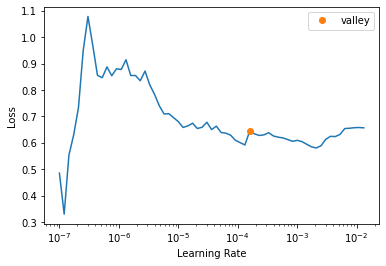

In [31]:
tuner.lr_find()

It recommends a learning rate of around 1e-4, so we will use that.

In [32]:
lr = 1e-4

Let's look at the documentation for `tune` function:

In [33]:
show_doc(tuner.tune)

<h4 id="AdaptiveTuner.tune" class="doc_header"><code>AdaptiveTuner.tune</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L364" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.tune</code>(**`epochs`**:`int`, **`lr`**:`float`=*`None`*, **`strategy`**:`Strategy`=*`'fit_one_cycle'`*, **`callbacks`**:`list`=*`[]`*, **\*\*`kwargs`**)

Fine tune `self.model` for `epochs` with an `lr` and `strategy`



We can pass in a number of epochs, a learning rate, a strategy, and additional fastai callbacks to call.

Valid strategies live in the `Strategy` namespace class, and consist of:
- OneCycle (Also called the [One-Cycle Policy](https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle))
- [CosineAnnealing](https://docs.fast.ai/callback.schedule.html#Learner.fit_flat_cos)
- [SGDR](https://docs.fast.ai/callback.schedule.html#Learner.fit_sgdr)

In [34]:
from adaptnlp import Strategy

In this tutorial we will train with the One-Cycle policy.

In [37]:
tuner.tune(3, lr, strategy=Strategy.OneCycle)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.611555,0.435229,0.810000,0.781609,00:05
1,0.367382,0.578555,0.782500,0.730650,00:05
2,0.209047,0.494948,0.825000,0.807692,00:05


## Saving Model

Now that we have a trained model, let's save those weights away.

Calling `tuner.save` will save both the model and the tokenizer in the same format as how HuggingFace does:

In [38]:
show_doc(tuner.save)

<h4 id="AdaptiveTuner.save" class="doc_header"><code>AdaptiveTuner.save</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L386" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.save</code>(**`save_directory`**)

Save a pretrained model to a `save_directory`

**Function Arguments**:
* `save_directory`: A folder to save our model to


In [39]:
tuner.save('good_model')

'good_model'

## Performing Inference

There are two ways to get predictions, the first is with the `.predict` method in our `tuner`. This is great for if you just finished training and want to see how your model performs on some new data!
The other method is with AdaptNLP's infernece API, which we will show afterwards

## In Tuner

First let's write a sentence ot test with

In [41]:
sentence = "This movie was horrible! Hugh Jackman is a terrible actor"

And then predict with it:

In [42]:
show_doc(tuner.predict)

<h4 id="SequenceClassificationTuner.predict" class="doc_header"><code>SequenceClassificationTuner.predict</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L272" class="source_link" style="float:right">[source]</a></h4>

> <code>SequenceClassificationTuner.predict</code>(**`text`**:`Union`\[`List`\[`str`\], `str`\], **`bs`**:`int`=*`64`*, **`detail_level`**:`DetailLevel`=*`'low'`*)

Predict some `text` for sequence classification with the currently loaded model

**Function Arguments**:
* `text` (`Union[List[str], str]`): Some text or list of texts to do inference with
* `bs` (`int`): A batch size to use for multiple texts
* `detail_level` (`DetailLevel `): A detail level to return on the predictions


In [43]:
tuner.predict(sentence)

{'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor'],
 'predictions': ['negative'],
 'probs': tensor([[0.9935, 0.0065]])}

### With the Inference API

Next we will use the `EasySequenceClassifier` class, which AdaptNLP offers:

In [44]:
from adaptnlp import EasySequenceClassifier

We simply construct the class:

In [45]:
classifier = EasySequenceClassifier()

And call the `tag_text` method, passing in the sentence, the location of our saved model, and some names for our classes:

In [46]:
classifier.tag_text(
    sentence,
    model_name_or_path='good_model',
    class_names=['negative', 'positive']
)

2021-08-02 14:37:46,609 loading file good_model


{'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor'],
 'predictions': ['negative'],
 'probs': tensor([[0.9935, 0.0065]])}

And we got the exact same output and probabilities!

There are also different levels of predictions we can return (which is also the same with our earlier `predict` call).

These live in a namespace `DetailLevel` class, with a few examples below:

In [47]:
from adaptnlp import DetailLevel

In [48]:
DetailLevel.Low

'low'

While some Easy modules will not return different items at each level, most will return only a few specific outputs at the Low level, and everything possible at the High level:

In [49]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.Low
)

{'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor'],
 'predictions': ['NEGATIVE'],
 'probs': tensor([[0.9935, 0.0065]])}

In [50]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.Medium
)

{'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor'],
 'predictions': ['NEGATIVE'],
 'probs': tensor([[0.9935, 0.0065]]),
 'pairings': OrderedDict([('This movie was horrible! Hugh Jackman is a terrible actor',
               tensor([0.9935, 0.0065]))]),
 'classes': ['NEGATIVE', 'POSITIVE']}

In [51]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.High
)

{'sentences': [Sentence: "This movie was horrible ! Hugh Jackman is a terrible actor"   [− Tokens: 11  − Sentence-Labels: {'sc': [NEGATIVE (0.9935), POSITIVE (0.0065)]}]],
 'predictions': ['NEGATIVE'],
 'probs': tensor([[0.9935, 0.0065]]),
 'pairings': OrderedDict([('This movie was horrible! Hugh Jackman is a terrible actor',
               tensor([0.9935, 0.0065]))]),
 'classes': ['NEGATIVE', 'POSITIVE']}